In [6]:
import os
import functools
from typing import *
from glob import glob
import pickle

import torch
import numpy as np
import pandas as pd

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataloader import DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
#from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.features import Manifold
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from altlabs.index_mapping import create_index_mapping
from altlabs.dataset import (
    noop,
    random_roll,
    SoftmaxDataset,
    limit_sequence_size,
    FactorizationDataset,
)
from altlabs.torch.data import FasterBatchSampler, NoAutoCollationDataLoader
from altlabs.utils import Pipeline

%matplotlib inline

In [7]:
softmax_model_paths = list(sorted(glob("output/56836160-1c29-4909-814d-b37d77e86ffc/tensorboard_logs_csv_logs/*/checkpoints/*.ckpt")))
lab_index_mapping_paths = list(sorted(glob("output/daaefeed-3f3f-43a0-b7c2-2abf04e31e72/tensorboard_logs_csv_logs/*/lab_index_mapping.pkl")))
from altlabs.model.conv1d_attn_softmax_classifier import Conv1dAttnSoftmaxClassifier, ModelConfig
softmax_models = [Conv1dAttnSoftmaxClassifier.load_from_checkpoint(path) for path in softmax_model_paths]

In [8]:
device = torch.device("cuda:0")

In [9]:
def extract_sequence_embedding(
    softmax_model, sequences: torch.Tensor, extra_inputs: torch.Tensor
) -> torch.Tensor:
    # Conv1d takes in (batch, channels, seq_len), but raw embedded is (batch, seq_len, channels)
    if softmax_model.model_config.sequence_embedding:
        x = softmax_model.sequence_embedding(sequences)
    else:
        x = one_hot_encode(sequences, softmax_model.model_config.vocab_size)

    # x = softmax_model.dropout_after_sequences(x)
    #if softmax_model.model_config.positional_encoding:
    x = softmax_model.position_encoding(x)
    # x = x.view(1, 1, -1)
    x = torch.squeeze(softmax_model.dropout_after_sequences(torch.unsqueeze(x, 0)))

    x = x.permute(0, 2, 1)

    x = torch.cat([softmax_model.convs_and_max_pool(convs, x) for convs in softmax_model.convs], 1)
    x = softmax_model.dropout_after_convs(x)


    if softmax_model.model_config.dense_hidden_dim > 0:
        x = softmax_model.activation(softmax_model.sequence_fc(x))
        x = softmax_model.dropout_after_sequence_fc(x)
    x = torch.cat((x, extra_inputs), 1)
    #x = softmax_model.dropout_before_output_fc(x)
    #x = softmax_model.sequence_output_fc(x)
    return x

In [10]:
train_values_df = pd.read_csv("../data/train_values_grouped.csv")
train_labels_df = pd.read_csv("../data/train_labels.csv")
input_columns = train_values_df.drop(columns=["sequence_id", "groups", "output"]).columns
output_columns = train_labels_df.drop(columns=["sequence_id"]).columns
occurrences = np.sum(train_labels_df[output_columns].values, axis=0)
softmax_filtered_out_output_columns = output_columns[
        occurrences < 2
    ]
softmax_train_labels_df = train_labels_df[
        np.sum(train_labels_df[softmax_filtered_out_output_columns].values, axis=1) == 0
    ]
softmax_output_columns = output_columns.drop(softmax_filtered_out_output_columns)
softmax_df = pd.merge(train_values_df, softmax_train_labels_df, on="sequence_id", how="right")
sequence_index_mapping = create_index_mapping(
    "ATGC", include_unkown=True, include_none=False,
)
sequence_index_mapping["N"] = 0

skf = StratifiedKFold(
            n_splits=4,
            random_state=42,
            shuffle=True,
        )
softmax_kfold = skf.split(softmax_df.index, softmax_df[softmax_output_columns].idxmax(axis=1))

sequence_embeddings = []
lab_index_mappings = []
labs = []
for n_fold, ((train_indices, val_indices), model, lab_index_mapping_path) in enumerate(zip(softmax_kfold, softmax_models, lab_index_mapping_paths)):
    if n_fold > 0:
        break
    model.to(device).eval()
    
    train_df = softmax_df[softmax_df.index.isin(val_indices)]
    
    with open(lab_index_mapping_path, "rb") as f:
        lab_index_mapping = pickle.load(f)
    lab_index_mappings.append(lab_index_mapping)
    
    train_dataset = FactorizationDataset(
        train_df,
        sequence_index_mapping,
        lab_index_mapping,
        input_columns,
        lab_column="output",
        negative_proportion=0.0,
        #transform_sequence_fn=transform_sequence_fn,
        test=True,
        bpe=True,
    )
    
    train_batch_sampler = FasterBatchSampler(
            train_dataset, 64, shuffle=False,
        )
    
    sequence_embedding: List[List[float]] = []
    with torch.no_grad():
        for indices in train_batch_sampler:
            batch = train_dataset[indices]
            if isinstance(batch[0], tuple):
                (sequences, extra_inputs, _) = batch[
                    0
                ]  # type: (torch.Tensor, torch.Tensor, torch.Tensor)
            else:
                (sequences, extra_inputs) = batch
            
            sequence_embedding.extend(extract_sequence_embedding(model, sequences.to(device), extra_inputs.to(device)).tolist())
            
    sequence_embedding = np.array(sequence_embedding)
    sequence_embeddings.append(sequence_embedding)
    labs.append(train_df["output"].values.tolist())
    
    lab_index_mappings.append(lab_index_mapping)
    
    model.cpu()

In [11]:
softmax_model = softmax_models[0]

In [12]:
reverse_lab_index_mapping = {value: key for key, value in lab_index_mappings[0].items()}

In [13]:
lab_names = [reverse_lab_index_mapping.get(i, "UNKNOWN") for i in range(max(reverse_lab_index_mapping.keys()))]

In [14]:
tsne_model = TSNE(perplexity=40, n_components=2, learning_rate=10.0, n_iter=2500, random_state=42, n_jobs=4)
new_values = tsne_model.fit_transform(normalize(sequence_embeddings[0]))

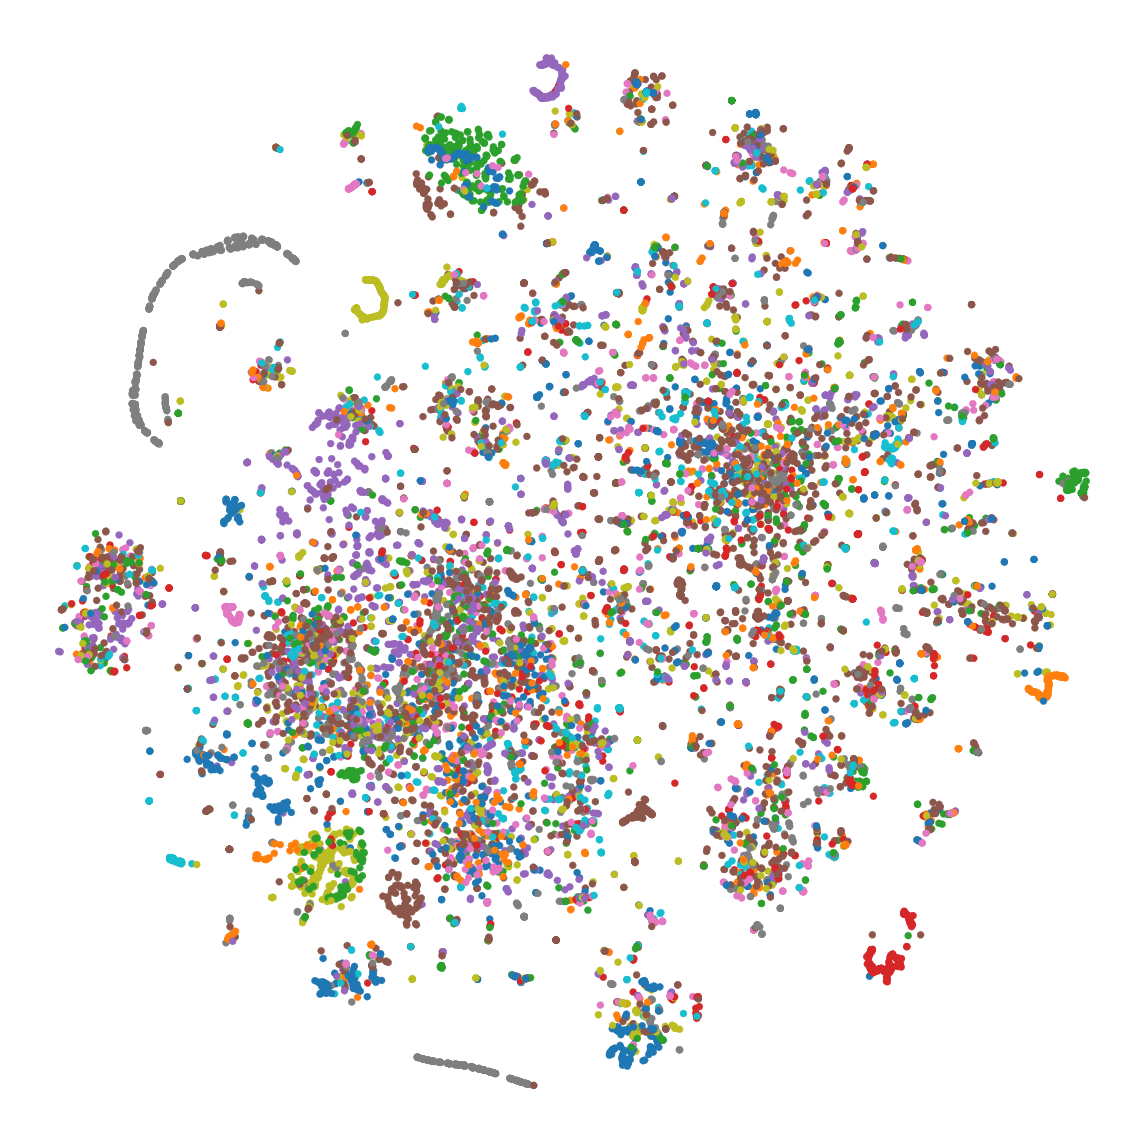

In [15]:
plt.figure(figsize=(16, 16))
plt.scatter(new_values[:, 0], new_values[:, 1], c=[lab_index_mappings[0][lab] for lab in labs[0]], cmap=plt.cm.get_cmap("tab10", max(lab_index_mappings[0].values())+1))
#for lab_name, xy in zip(lab_names, new_values[len(sequence_embeddings[0]):]):
#    plt.annotate(lab_name,
#                 xy=xy,
#                 xytext=(5, 2),
#                 textcoords='offset points',
#                 ha='right',
#                 va='bottom')
plt.axis('off')
plt.tight_layout()
plt.savefig('../results/tsne_softmax_val.png', format='png')
plt.show()